In [1]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import datetime
import pandas as pd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
theano.config.optimizer='fast_run'
theano.config.floatX = "float64"

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner

In [5]:
def plain_SIR_model(beta,gamma,N,S0,I0,R0,l=150):
    """Simple classical SIR-Model with time-constant beta,gamma"""
    def next_day(t,St,It,Rt,oS,oI,oR,eff,beta,gamma,N):
        eff = beta*St/N
        bSIoN = eff * It # -beta * (S*I)/N
        gI = gamma*It
        # Calculate differences
        dS = -bSIoN
        dI = bSIoN - gI
        dR = gI
        # Update values
        nxt_St = St + dS
        nxt_It = It + dI
        nxt_Rt = Rt + dR
        
        nxt_St = tt.clip(nxt_St,0,1e16) # Improves sampling stability
        
        # Pass on to next step
        return nxt_St,nxt_It,nxt_Rt, dS,dI,dR, eff
        
    # Initial internal state
    zero = tt.cast(0.,dtype='float64')
    initial_state = [S0,I0,R0,zero,zero,zero,zero]
    sequences = [tt.arange(l)]
    # Exceute the 'Loop'
    state,_ = theano.scan(fn=next_day,
                            sequences=sequences,# time dependent sequences can be passed as first params
                            outputs_info=initial_state,
                            non_sequences=[beta,gamma,N])
    return state


def Gompertz(a,b,c,l=150):
    t = tt.arange(l)
    return a*tt.exp(-b*tt.exp(-c*t))

In [36]:
with open("estimates/sir_1598863829","rb") as f:
    sir_est = pickle.load(f)
    
with open("estimates/gomp_1598868142","rb") as f:
    gomp_est = pickle.load(f)

In [53]:
# Transpose the Dataset for the SIR-Fit
b,g,n,i0 = tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64"),tt.scalar(dtype="float64")
i = tt.scalar(dtype="int64")
z = tt.constant(0.,dtype='float64')
S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(b,g,n,n,i0,z,i)
sat_f = theano.function(inputs=[b,g,n,i0,i],outputs=R_t[-1])

t0 = time.time()
estimation_series = {}
for k,v in sir_est.items():
    if "ssd" not in estimation_series.keys():
        estimation_series["ssd"] = []
    estimation_series["ssd"].append(v["ssd"])
    for p in ['beta','gamma','N','I0']:
        if p not in estimation_series.keys():
            estimation_series[p] = {"mu":[],2.5:[],16:[],50:[],84:[] ,97.5:[]} 
        es = estimation_series[p]
        es["mu"].append(np.mean(v[p]))
        q = np.percentile(v[p],q=(2.5,16,50,84,97.5))
        es[2.5].append(q[0])
        es[16].append(q[1])
        es[50].append(q[2])
        es[84].append(q[3])
        es[97.5].append(q[4])
        
    sat = []
    for i,beta,gamma,N,I0 in zip(range(len(v["beta"])),v["beta"],v["gamma"],v["N"],v["I0"]):
        sat.append( sat_f(beta,gamma,N,I0,300) )
    
    if "saturation" not in estimation_series.keys():
        estimation_series["saturation"] = {"mu":[],2.5:[],16:[],50:[],84:[],97.5:[]} 
    es = estimation_series["saturation"]
    sata = np.array(sat)
    q = np.percentile(sata,q=(2.5,16,50,84,97.5))
    es["mu"].append(np.mean(sata))
    es[2.5].append(q[0])
    es[16].append(q[1])
    es[50].append(q[2])
    es[84].append(q[3])
    es[97.5].append(q[4])
    
#    print(k,v["ssd"],np.mean(v["N"]),np.mean(sata))
t1 = time.time()
print("Recalculate SIR for saturation in %.2fs"%(t1-t0))
sir_est_series = estimation_series


Recalculate SIR for saturation in 319.18s


In [51]:
# Transpose the Dataset for the Gompertz-Fit

estimation_series = {}
for k,v in gomp_est.items():
    if "ssd" not in estimation_series.keys():
        estimation_series["ssd"] = []
    estimation_series["ssd"].append(v["ssd"])
    for p in ['a','b','c']:
        if p not in estimation_series.keys():
            estimation_series[p] = {"mu":[],2.5:[],16:[],50:[],84:[],97.5:[]} 
        es = estimation_series[p]
        es["mu"].append(np.mean(v[p]))
        q = np.percentile(v[p],q=(2.5,16,50,84,97.5))
        es[2.5].append(q[0])
        es[16].append(q[1])
        es[50].append(q[2])
        es[84].append(q[3])
        es[97.5].append(q[4])
        
#    print(k,v["ssd"],np.mean(v["a"]))

gomp_est_series = estimation_series

(0.0, 30000.0)

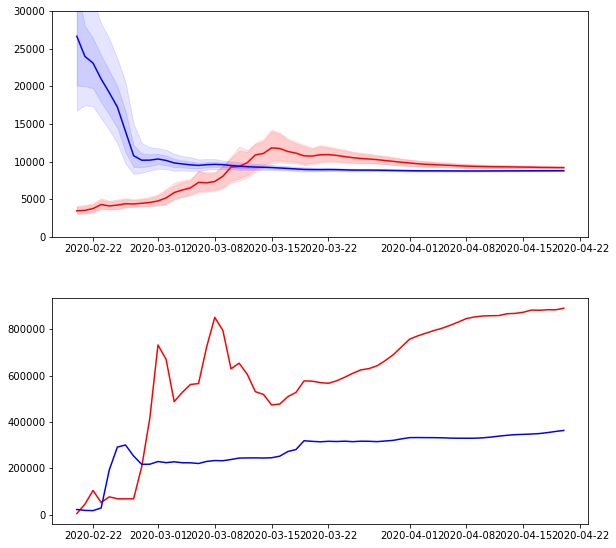

In [52]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)

ts = pd.date_range(datetime.date(2020,1,21),periods=91,freq='D')

gs = fig.add_gridspec(2, 1)


ax = fig.add_subplot(gs[0,0])
bx = fig.add_subplot(gs[1,0])
c = "red"
bx.plot(ts[30:],sir_est_series["ssd"],color=c)
ax.plot(ts[30:],sir_est_series["saturation"]["mu"],color=c)
ax.fill_between(ts[30:],sir_est_series["saturation"][2.5],sir_est_series["saturation"][97.5],alpha=.1,color=c)
ax.fill_between(ts[30:],sir_est_series["saturation"][5],sir_est_series["saturation"][95],alpha=.1,color=c)
c = "blue"
bx.plot(ts[30:],gomp_est_series["ssd"],color=c)
ax.plot(ts[30:],gomp_est_series["a"]["mu"],color=c)
ax.fill_between(ts[30:],gomp_est_series["a"][2.5],gomp_est_series["a"][97.5],alpha=.1,color=c)
ax.fill_between(ts[30:],gomp_est_series["a"][16],gomp_est_series["a"][84],alpha=.1,color=c)

ax.set_ylim([0,30000])